In [1]:
# Importing necessary packages
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

In [2]:
# 1.) Defining the 27 Power-Variance players
players = [
    "Oneil_Cruz", "James_Wood", "Ryan_McMahon", "Riley_Greene",
    "Eugenio_Suárez", "Elly_De_La_Cruz", "Kyle_Schwarber", "Jo_Adell",
    "Teoscar_Hernández", "Spencer_Torkelson", "Lawrence_Butler",
    "Randy_Arozarena", "Adolis_García", "Jazz_Chisholm_Jr",
    "Christian_Walker", "Michael_Busch", "Willy_Adames", "Taylor_Ward",
    "Rafael_Devers", "Brent_Rooker", "Zach_Neto", "Matt_Olson",
    "Marcell_Ozuna", "Ian_Happ", "Pete_Crow-Armstrong",
    "Pete_Alonso", "Shea_Langeliers"
]

In [3]:
# 2.) Setting a parquet directory path
parquet_dir = r"C:\Users\andre\Documents\Documents\Syracuse\JUNIOR YEAR\SPRING 2026\SAL 358\SABR26\Simulations\output"

In [4]:
# 3.) Loading all parquets into a dict and a combined df
player_dfs = {}
missing    = []

for player in players:
    path = os.path.join(parquet_dir, f"{player}_simulation.parquet")
    if os.path.exists(path):
        df = pd.read_parquet(path)
        df["player"] = player.replace("_", " ")
        player_dfs[player] = df
    else:
        missing.append(player)

if missing:
    print(f" Missing parquet files for: {missing}")
else:
    print(f" All 27 parquet files loaded successfully")

 All 27 parquet files loaded successfully


In [5]:
# 4.) Combine into one df
data_all = pd.concat(player_dfs.values(), ignore_index=True)

print(f"\nCombined shape: {data_all.shape}")


Combined shape: (40824000, 39)


In [6]:
# 5.) Initial exploration
print("\n── Column Names ──")
print(data_all.columns.tolist())

print("\n── Data Types ──")
print(data_all.dtypes)

print("\n── First 5 Rows ──")
print(data_all.head())

print("\n── Basic Summary Stats ──")
print(data_all.describe())

print("\n── Null Counts ──")
print(data_all.isnull().sum()[data_all.isnull().sum() > 0])

print("\n── Players in Combined df ──")
print(data_all["player"].value_counts())


── Column Names ──
['batter_id', 'player_name', 'baseline_bat_speed', 'baseline_swing_length', 'baseline_z_contact', 'baseline_xiso', 'baseline_o_swing_pct', 'bat_speed_change_pct', 'swing_length_change_pct', 'new_bat_speed', 'new_swing_length', 'adjusted_z_contact', 'adjusted_xiso', 'pitcher_xfip_percentile', 'pitcher_xfip_value', 'count', 'outs', 'base_state', 'base_state_name', 'inning', 'inning_topbot', 'score_diff', 'wp_before_pa', 'baseline_wp_after_pa', 'adjusted_wp_after_pa', 'wp_diff_from_baseline', 'feasibility_density', 'is_feasible', 'player_bs_std', 'player_sl_std', 'player_bs_sl_corr', 'prob_K', 'prob_BB_HBP', 'prob_field_out', 'prob_1B', 'prob_2B', 'prob_3B', 'prob_HR', 'player']

── Data Types ──
batter_id                    int64
player_name                    str
baseline_bat_speed         float64
baseline_swing_length      float64
baseline_z_contact         float64
baseline_xiso              float64
baseline_o_swing_pct       float64
bat_speed_change_pct       float

In [ ]:

# ------------------------------------------ PLOTS ---------------------------------------------------------------------------------------------------


In [8]:
os.chdir(r"C:\Users\andre\Documents\Documents\Syracuse\JUNIOR YEAR\SPRING 2026\SAL 358\SABR26\Plots")

In [9]:
# Shared style
PALETTE   = ["#1b7837", "#4393c3", "#2d9e9e", "#6baed6",
             "#807dba", "#54278f", "#00798c", "#e08214"]
TITLE_KW  = dict(fontsize=16, fontweight="bold", ha="center")
LABEL_KW  = dict(fontsize=13, fontweight="bold")

def fmt_ax(ax, title, xlabel=None, ylabel=None):
    ax.set_title(title, **TITLE_KW)
    if xlabel: ax.set_xlabel(xlabel, **LABEL_KW)
    if ylabel: ax.set_ylabel(ylabel, **LABEL_KW)

def save(name):
    plt.tight_layout()
    plt.savefig(f"{name}.png", dpi=300, bbox_inches="tight")
    plt.show()

# Filter to feasible adjustments only where relevant (is_feasible == 1)
feasible = data_all[data_all["is_feasible"] == 1].copy()

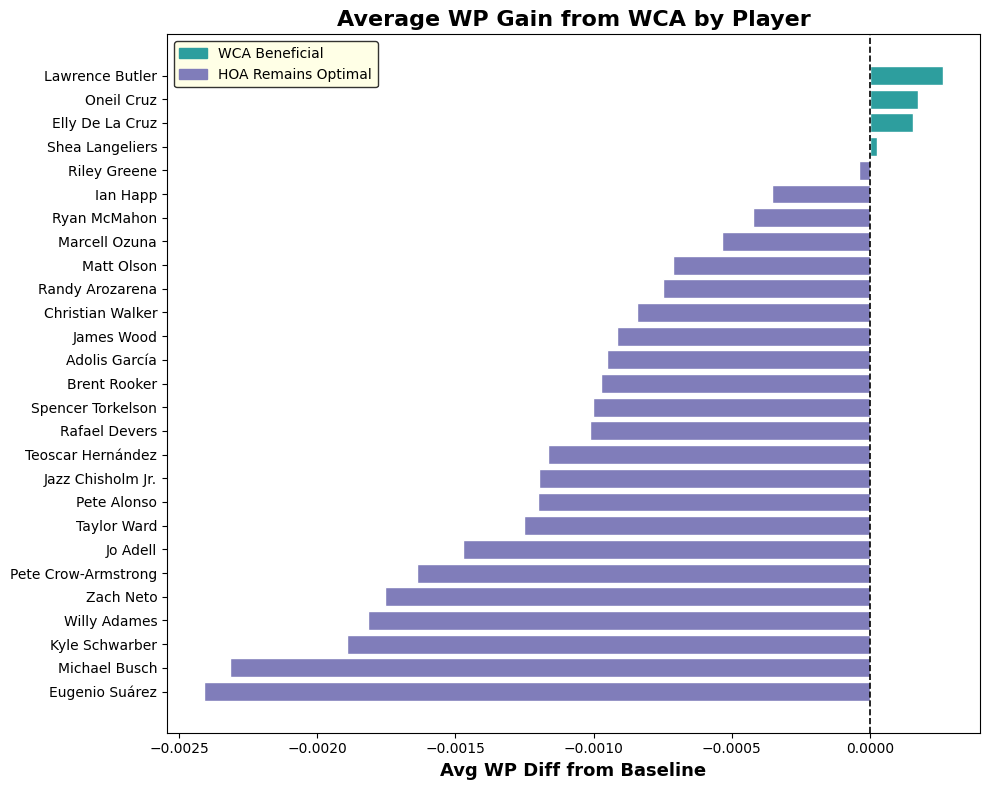

In [10]:
# PLOT 1: WHO BENEFITS MOST — avg WP diff by player (feasible PAs only)
# Answers: "Which hitters are most likely to benefit?"

player_wp = (feasible.groupby("player_name")["wp_diff_from_baseline"]
             .mean().reset_index()
             .sort_values("wp_diff_from_baseline", ascending=True))

colors = ["#2d9e9e" if v > 0 else "#807dba"
          for v in player_wp["wp_diff_from_baseline"]]

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(player_wp["player_name"], player_wp["wp_diff_from_baseline"],
        color=colors, edgecolor="white")
ax.axvline(0, color="black", linewidth=1.2, linestyle="--")
fmt_ax(ax,
       "Average WP Gain from WCA by Player",
       "Avg WP Diff from Baseline", None)
ax.tick_params(axis="y", labelsize=10)
patch_pos = mpatches.Patch(color="#2d9e9e", label="WCA Beneficial")
patch_neg = mpatches.Patch(color="#807dba", label="HOA Remains Optimal")
ax.legend(handles=[patch_pos, patch_neg], fontsize=10,
          facecolor="lightyellow", edgecolor="black")

save("each_player_wp_gain")

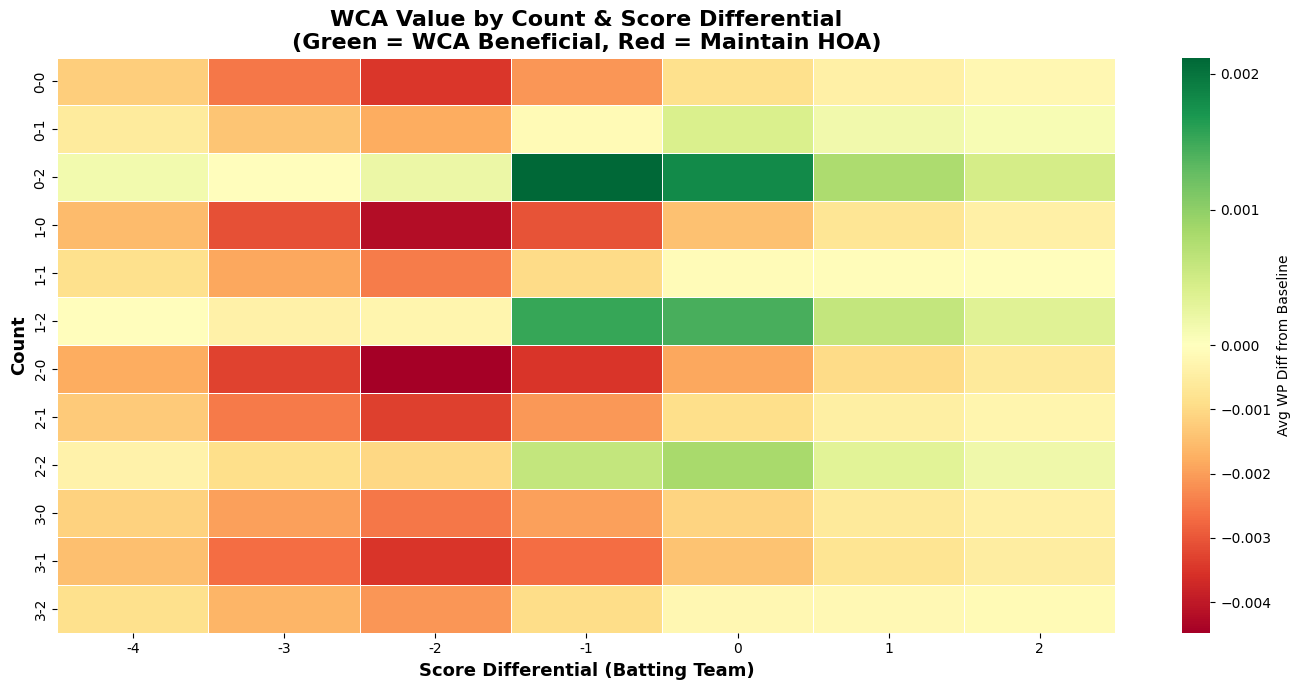

In [11]:
# PLOT 2: WHEN TO SHIFT — WP diff heatmap by Count × Score Differential
# Answers: "Define conditions under which WCA outweighs HOA"

count_order = ["0-0","0-1","0-2","1-0","1-1","1-2",
               "2-0","2-1","2-2","3-0","3-1","3-2"]

heatmap_data = (feasible.groupby(["count", "score_diff"])["wp_diff_from_baseline"]
                .mean().reset_index()
                .pivot(index="count", columns="score_diff",
                       values="wp_diff_from_baseline"))
heatmap_data = heatmap_data.reindex(count_order)

norm = TwoSlopeNorm(vmin=heatmap_data.values.min(),
                    vcenter=0,
                    vmax=heatmap_data.values.max())

fig, ax = plt.subplots(figsize=(14, 7))
sns.heatmap(heatmap_data, cmap="RdYlGn", norm=norm, ax=ax,
            linewidths=0.4, linecolor="white",
            cbar_kws={"label": "Avg WP Diff from Baseline"})
fmt_ax(ax,
       "WCA Value by Count & Score Differential\n(Green = WCA Beneficial, Red = Maintain HOA)",
       "Score Differential (Batting Team)", "Count")
ax.tick_params(axis="both", labelsize=10)

save("heatmap_count_score")

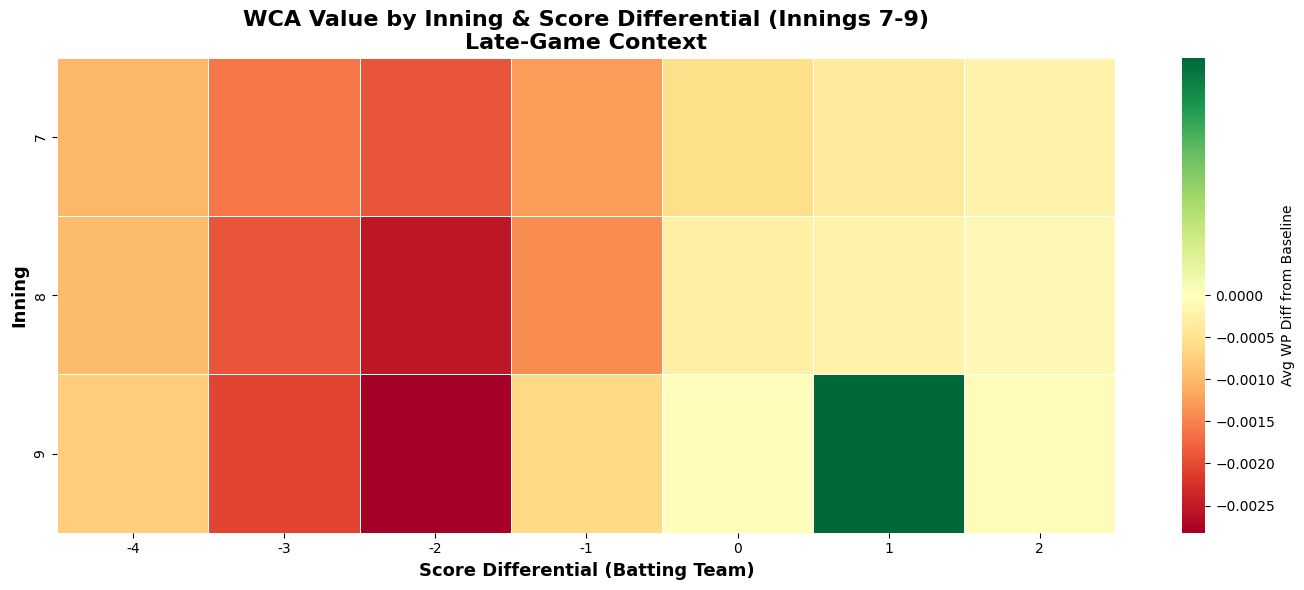

In [14]:
# PLOT 3: LATE INNING LEVERAGE — WP diff by inning × score_diff
# Answers: "When should they shift given the objective of winning"

late = feasible[feasible["inning"] >= 6].copy()

inning_heat = (late.groupby(["inning", "score_diff"])["wp_diff_from_baseline"]
               .mean().reset_index()
               .pivot(index="inning", columns="score_diff",
                      values="wp_diff_from_baseline"))

norm2 = TwoSlopeNorm(vmin=inning_heat.values.min(),
                     vcenter=0,
                     vmax=inning_heat.values.max())

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(inning_heat, cmap="RdYlGn", norm=norm2, ax=ax,
            linewidths=0.4, linecolor="white",
            cbar_kws={"label": "Avg WP Diff from Baseline"})
fmt_ax(ax,
       "WCA Value by Inning & Score Differential (Innings 7-9)\nLate-Game Context",
       "Score Differential (Batting Team)", "Inning")

save("heatmap_inning_score")

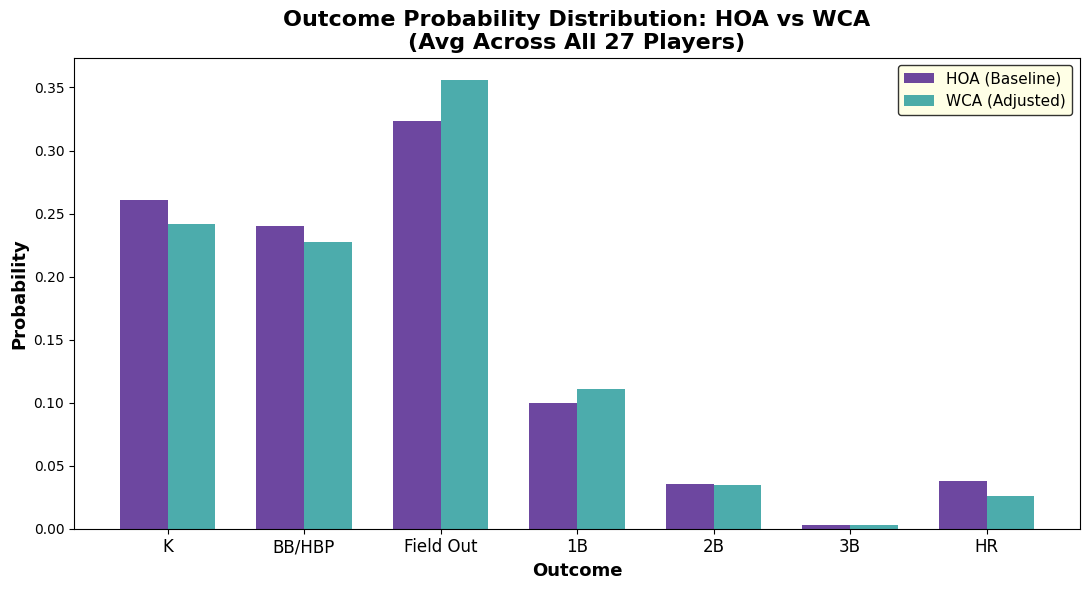

In [15]:
# PLOT 4: DISTRIBUTIONAL SHIFT — baseline vs adjusted outcome probs
# Answers: "Explain the tradeoff using distributional reasoning"

outcome_cols = ["prob_K", "prob_BB_HBP", "prob_field_out",
                "prob_1B", "prob_2B", "prob_3B", "prob_HR"]
outcome_labels = ["K", "BB/HBP", "Field Out", "1B", "2B", "3B", "HR"]

baseline_means = feasible[feasible["bat_speed_change_pct"] == 0][outcome_cols].mean()
adjusted_means = feasible[feasible["bat_speed_change_pct"] != 0][outcome_cols].mean()

x      = np.arange(len(outcome_labels))
width  = 0.35

fig, ax = plt.subplots(figsize=(11, 6))
ax.bar(x - width/2, baseline_means, width, label="HOA (Baseline)",
       color="#54278f", alpha=0.85)
ax.bar(x + width/2, adjusted_means, width, label="WCA (Adjusted)",
       color="#2d9e9e", alpha=0.85)
ax.set_xticks(x)
ax.set_xticklabels(outcome_labels, fontsize=12)
fmt_ax(ax,
       "Outcome Probability Distribution: HOA vs WCA\n(Avg Across All 27 Players)",
       "Outcome", "Probability")
ax.legend(fontsize=11, facecolor="lightyellow", edgecolor="black")

save("outcome_distribution_shift")

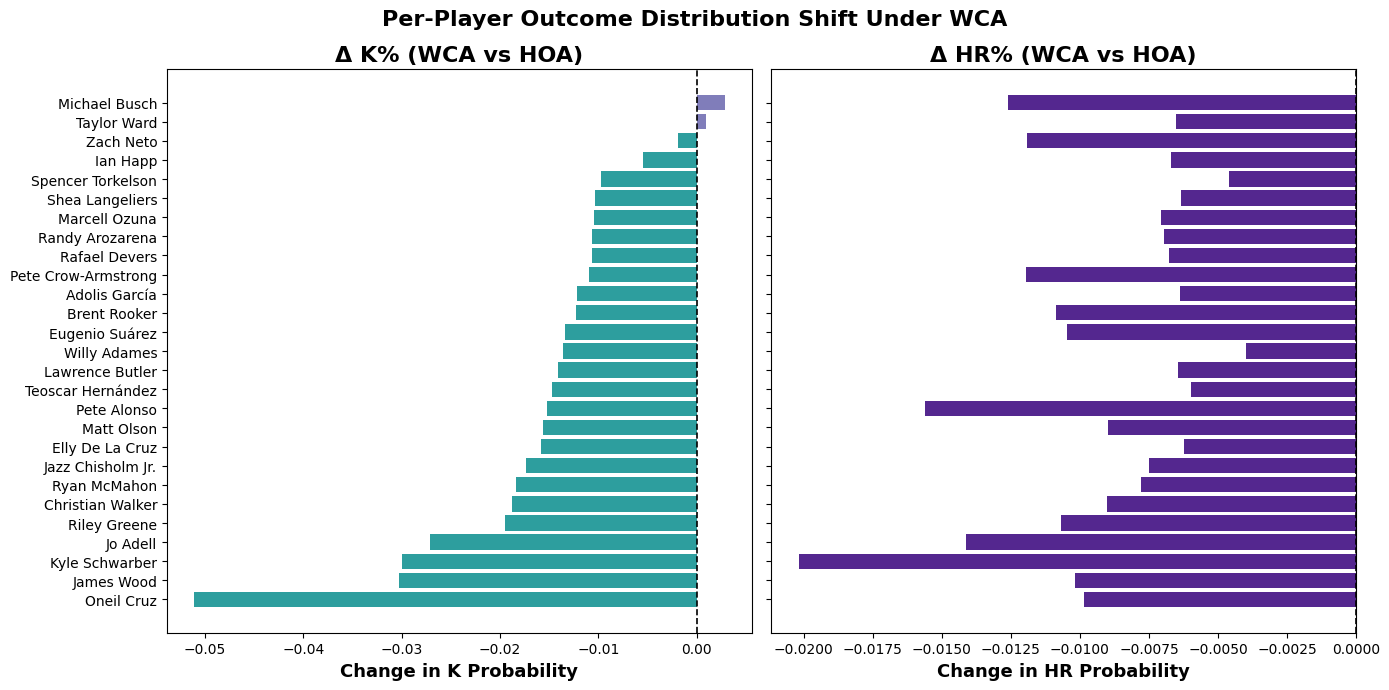

In [16]:
# PLOT 5: PER-PLAYER DISTRIBUTIONAL SHIFT in K% and HR%
# Answers: "Distributional reasoning — not averages"

per_player = (feasible.groupby("player_name")[["prob_K", "prob_HR"]]
              .mean().reset_index())
base_player = (feasible[feasible["bat_speed_change_pct"] == 0]
               .groupby("player_name")[["prob_K", "prob_HR"]]
               .mean().reset_index()
               .rename(columns={"prob_K": "base_K", "prob_HR": "base_HR"}))

shift_df = per_player.merge(base_player, on="player_name")
shift_df["delta_K"]  = shift_df["prob_K"]  - shift_df["base_K"]
shift_df["delta_HR"] = shift_df["prob_HR"] - shift_df["base_HR"]
shift_df = shift_df.sort_values("delta_K")

fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

axes[0].barh(shift_df["player_name"], shift_df["delta_K"],
             color=["#2d9e9e" if v < 0 else "#807dba" for v in shift_df["delta_K"]])
axes[0].axvline(0, color="black", linewidth=1.2, linestyle="--")
fmt_ax(axes[0], "Δ K% (WCA vs HOA)", "Change in K Probability", None)

axes[1].barh(shift_df["player_name"], shift_df["delta_HR"],
             color=["#54278f" if v < 0 else "#1b7837" for v in shift_df["delta_HR"]])
axes[1].axvline(0, color="black", linewidth=1.2, linestyle="--")
fmt_ax(axes[1], "Δ HR% (WCA vs HOA)", "Change in HR Probability", None)

fig.suptitle("Per-Player Outcome Distribution Shift Under WCA",
             fontsize=16, fontweight="bold")

save("player_distribution_shift")

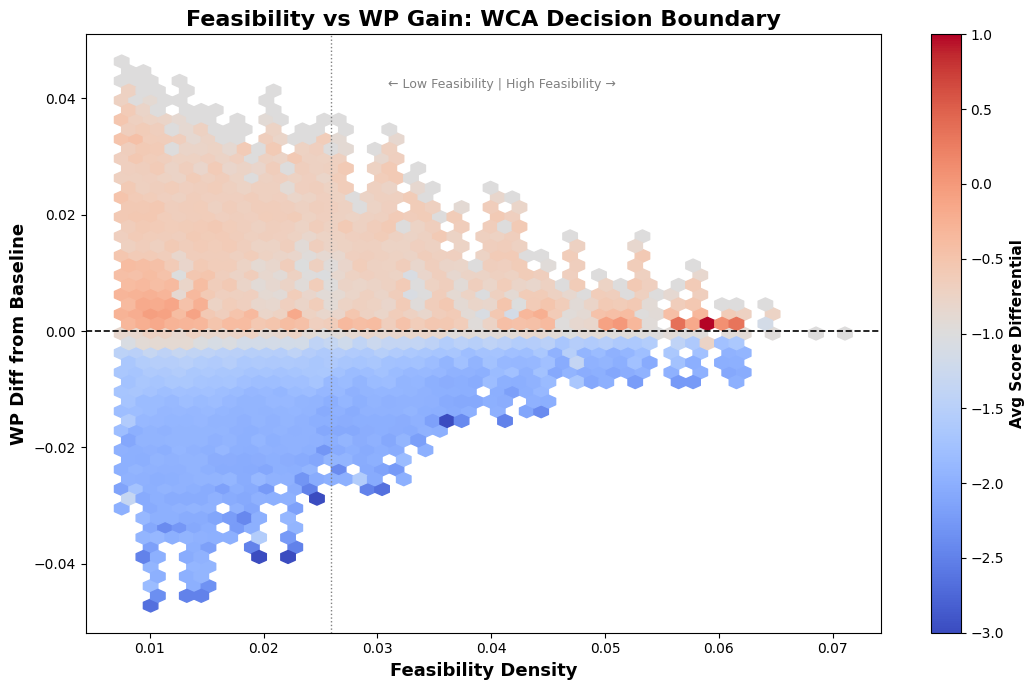

In [20]:
# PLOT 6: WCA vs HOA DECISION BOUNDARY — feasibility × WP gain
# Answers: "Distinguish states where WCA is value-enhancing vs HOA optimal"

sample = feasible.copy()

fig, ax = plt.subplots(figsize=(11, 7))
sc = ax.hexbin(sample["feasibility_density"],
               sample["wp_diff_from_baseline"],
               C=sample["score_diff"],
               reduce_C_function=np.mean,
               gridsize=50, cmap="coolwarm",
               rasterized=True)
ax.axhline(0, color="black", linewidth=1.2, linestyle="--")
ax.axvline(feasible["feasibility_density"].median(),
           color="gray", linewidth=1, linestyle=":")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Avg Score Differential", fontsize=11, fontweight="bold")
fmt_ax(ax,
       "Feasibility vs WP Gain: WCA Decision Boundary",
       "Feasibility Density", "WP Diff from Baseline")
ax.text(sample["feasibility_density"].median() + 0.005,
        sample["wp_diff_from_baseline"].max() * 0.9,
        "← Low Feasibility | High Feasibility →",
        fontsize=9, color="gray")

save("feasibility_wp_scatter")